In [87]:
# adapted from:
# https://ucdavis-bioinformatics-training.github.io/2018-June-RNA-Seq-Workshop/thursday/DE.html
# https://rpubs.com/jrgonzalezISGlobal/transcriptomic_analyses
# https://ucdavis-bioinformatics-training.github.io/2018-September-Bioinformatics-Prerequisites/friday/limma_biomart_vignettes.html
# https://github.com/kevinblighe/EnhancedVolcano

In [148]:
# Dependencies

suppressWarnings(library(edgeR))
suppressWarnings(library(EnhancedVolcano))
suppressWarnings(library(patchwork)) # combine plots
suppressWarnings(library(magrittr))
suppressWarnings(library(tibble))
suppressWarnings(library(repr))
suppressWarnings(library(stringr))
suppressWarnings(library(dplyr))
suppressWarnings(library(ggplot2))
suppressWarnings(library(extrafont))
suppressWarnings(library(svglite))

suppressMessages(extrafont::font_import(pattern="Arial",prompt=FALSE))
suppressMessages(extrafont::loadfonts())

In [121]:
# Data
dir.create("figures", showWarnings = FALSE)
dir.create("out", showWarnings = FALSE)

path_to_counts =  "/Users/ochapman/Library/CloudStorage/OneDrive-SanfordBurnhamPrebysMedicalDiscoveryInstitute/projects/2023-pedpancan/data/gex/pbta-rsem-genes.expected_count.tsv"
path_to_annotation = "/Users/ochapman/Library/CloudStorage/OneDrive-SanfordBurnhamPrebysMedicalDiscoveryInstitute/projects/2023-pedpancan/data/gex/sample_phenotypes.csv"
filter_genes <- function(gene_matrix){
    patterns <- "^ENSG|^LINC|-AS\\d$|^PAR_Y_|-DT$|-OT\\d$"
    rows_to_remove <- grep(patterns, rownames(gene_matrix))

    # Subset the matrix to exclude these rows
    filtered_data <- gene_matrix[-rows_to_remove, ]
    return (filtered_data)
}
load_inputs <- function(cts_path,annot_path){
    message("loading data...")
    cts = as.matrix(read.csv(cts_path,sep='\t',row.names="Gene_or_Transcript_ID",check.names=FALSE))
    annot = read.csv(annot_path,row.names=1)

    cts = round(cts) # counts must be integer
    cts <- cts[, rownames(annot)] # only include samples with metadata
    new_rownames <- sub("^ENSG\\d*\\.\\d*_", "", rownames(cts)) # Remove prefixes ending with '_' from the row names
    rownames(cts) <- new_rownames # Update the row names of the matrix
    cts = filter_genes(cts) # remove common noncoding RNAs
    annot$age_at_diagnosis <- (annot$age_at_diagnosis - mean(annot$age_at_diagnosis)) / sd(annot$age_at_diagnosis) 
    annot <- annot[,c("sex","tumor_history","age_at_diagnosis","extent_of_tumor_resection","cancer_type","amplicon_class")]

    stopifnot(all(rownames(annot) == colnames(cts)))
    return(list(cts=cts,annot=annot))
}
data=load_inputs(path_to_counts,path_to_annotation) # this will take awhile

loading data...



In [124]:
head(data$cts)

,7316-272,7316-447,7316-6365,7316-898,7316-1702,7316-7091,7316-6811,7316-8116,7316-746,7316-5423,⋯,7316-2860,7316-6773,7316-117,7316-2666,7316-7515,7316-7675,7316-725,7316-6666,7316-2723,7316-2758
TSPAN6,2470,1385,999,1269,159,21140,8690,17046,420,888,⋯,3670,3762,2428,1092,952,818,683,14312,623,5632
TNMD,43,9,0,0,1,18,203,10,1,0,⋯,4,21,6,0,5,12,8,72,3,15
DPM1,1111,634,3028,738,939,3108,2396,1413,878,1992,⋯,1194,1161,753,607,1249,1278,740,2116,669,875
SCYL3,993,547,1376,650,364,1273,1093,606,1229,483,⋯,1101,899,771,865,585,801,635,1138,674,287
C1orf112,450,437,180,444,231,554,369,323,594,321,⋯,225,265,210,174,151,111,255,373,416,91
FGR,284,113,163,1169,749,624,243,111,245,409,⋯,319,487,228,289,461,366,338,109,376,156


In [123]:
## lots of R pacakges work by creating a data *object* and performing matematical transformations on the structured data within.
# https://www.rdocumentation.org/packages/edgeR/versions/3.14.0/topics/DGEList-class
dge <- DGEList(data$cts)

formula = ~ data$annot$sex + data$annot$tumor_history + data$annot$age_at_diagnosis + data$annot$extent_of_tumor_resection + data$annot$cancer_type + data$annot$amplicon_class
#formula = ~ data$annot$extent_of_tumor_resection + data$annot$cancer_type + data$annot$amplicon_class
design <- model.matrix(formula)

# https://rdrr.io/bioc/edgeR/man/filterByExpr.html
keep <- filterByExpr(dge,design=design)
dge <- dge[keep,]

# gene counts from RNA-seq are influenced by technical factors such as library size and sequencing depth, which do not reflect true
# biological variation. There are various algorithms to *normalize* RNA-seq data. Here we use trimmed mean of M values, TMM.
# https://www.rdocumentation.org/packages/edgeR/versions/3.14.0/topics/calcNormFactors
dge <- calcNormFactors(dge,method="TMM")


Fitting voom normalization...

Fitting linear model...

Calculating emperical bayes statistics...



[1] "data$annot$amplicon_classecDNA"
[1] 26768  1370


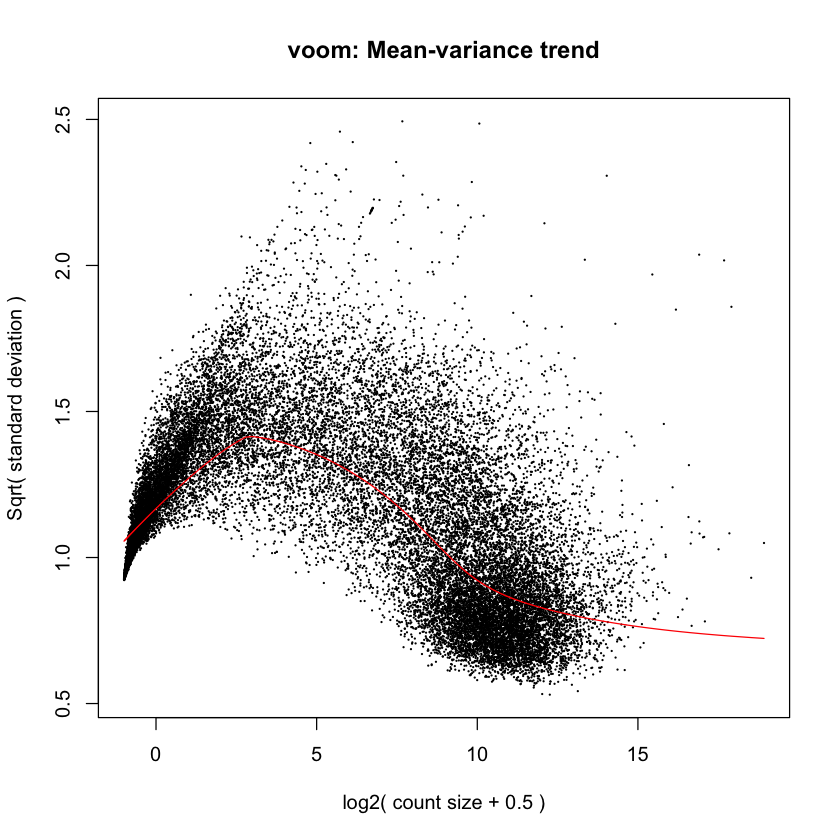

In [216]:
# This takes a minute
options(repr.plot.width=7, repr.plot.height=7)
message("Fitting voom normalization...")
v <- voom(dge, design, plot=TRUE)

message("Fitting linear model...")
fit <- lmFit(v,design)

message("Calculating emperical bayes statistics...")
fit <- eBayes(fit,robust=TRUE)

# Apply multiple testing correction and obtain stats
comparison = ncol(design)-1
print(colnames(design)[comparison]) # This is the 
stats_df <- topTable(fit,n=Inf,coef=comparison) %>% tibble
print(dim(dge))

In [291]:
# Seal, R.L., Denny, P., Bruford, E.A. et al. A standardized nomenclature for mammalian histone genes. Epigenetics & Chromatin 15, 34 
# (2022). https://doi.org/10.1186/s13072-022-00467-2
H_pseudogenes = c('H1-9P','H1-12P','H2AC2P','H2AC3P','H2AC5P','H2AC9P','H2AC10P','H2AQ1P','H2AL1MP','H2BC2P','H2BC19P','H2BC20P',
                 'H2BC16P','H2BL1P','H2BU2P','H2BW3P','H2BW4P','H3C5P','H3C9P','H3P16','H3P44','H4C10P',
                 'H2AZP7','H2AZ2P1','H2AZP2','H2AZP5','H2BP2','H2BP3','H2BP9','H4P1','H2BP1','H2AL1QP','H3P18','H3P21','H3P3','H3P1','H3P4',
                 'H3P37','H3P31','H3P14','H3P47','H3P6','H3P39','H3P13') # H2BU2P = H2BC27P
H1 = c('H1-0','H1-1','H1-2','H1-3','H1-4','H1-5','H1-6','H1-7','H1-8','H1-10')
H2A_clustered = c('H2AC1','H2AC4','H2AC6','H2AC7','H2AC8','H2AC11','H2AC12',
                'H2AC13','H2AC14','H2AC15','H2AC16','H2AC17','H2AC18','H2AC19','H2AC20','H2AC21','H2AW') # H2AW = H2AC25
H2A = c('H2AZ1','H2AZ2','MACROH2A1','MACROH2A2','H2AX','H2AJ','H2AB1','H2AB2','H2AB3','H2AP','H2AL3')
H2B_clustered = c('H2BC1','H2BC3','H2BC4','H2BC5','H2BC6','H2BC7','H2BC8','H2BC9','H2BC10','H2BC11','H2BC12',
                 'H2BC13','H2BC14','H2BC15','H2BC17','H2BC18','H2BC21','H2BU1') # H2BU1 = H2BC26
H2B = c('H2BE1','H2BW1','H2BW2','H2BN1','H2BS1') # H2BS1 = H2BC12L; H2BE1 = H2BK1
H3_clustered = c('H3C1','H3C2','H3C3','H3C4','H3C6','H3C7','H3C8','H3C10','H3C11','H3C12','H3C13','H3C14','H3C15')
H3 = c('H3-3A','H3-3B','H3-4','H3-5','H3-2','H3Y1','H3Y2','CENPA') # H3-2 = H3-7
H4_clustered = c('H4C1','H4C2','H4C3','H4C4','H4C5','H4C6','H4C7','H4C8','H4C9','H4C11','H4C12','H4C13','H4C14','H4C15')
H4 = c('H4-16')
rdh = c(H2A_clustered,H2B_clustered,H3_clustered,H4_clustered)
nrdh = c(H1,H2A,H2B,H3,H4)
all_histones = c(rdh,nrdh,H_pseudogenes)

In [339]:
hits <- stats_df %>% 
    #filter(adj.P.Val < 0.10) %>%
    arrange(logFC)
write.table(hits, file='out/differential_expression.tsv',quote=FALSE,sep='\t')

In [140]:
# These histones are missing in the expression dataset
all_histones[!(all_histones %in% stats_df$ID)]

[1] "H4C7"   "H2BN1"  "H2AC2P" "H2AC3P" "H2AC9P" "H2AQ1P" "H2BL1P" "H2BW4P"
 [9] "H3P44"  "H3P3"   "H3P1"

In [292]:
# These genes are not in my histone sets
stats_df$ID[str_starts(stats_df$ID,'H[1-4]') & !(stats_df$ID %in% all_histones)]

[1] "H19"

In [132]:
write_gene_sets <- function(){
    vectors = list(rdh, nrdh, H_pseudogenes)
    names = c("replication_dependent_histones","constitutive_histones","histone_pseudogenes")
    # Open a connection to the output file
    file_conn <- file("out/histone-sets.gmt", open = "wt")
    # Write each set to the file
    for (i in seq_along(names)) {
      # Combine the name, description, and vector into a single row
      row <- c(names[i], "custom_gene_set", vectors[[i]])
      # Write the row to the file, separated by tabs
      writeLines(paste(row, collapse = "\t"), file_conn)
    }
    
    # Close the file connection
    close(file_conn)
}
write_gene_sets()

In [336]:
## Plotting code

color_code <- list(
  "replication-dependent histones" = "blue",
  "constitutive histones" = "darkgreen ",
  "histone pseudogenes" = "darkorange",
  "other" = "grey50",
  'c-NHEJ' = 'royalblue3',
  'Alt-EJ' = 'darkblue',
  'SSA' = 'blue3',
  'HR' = 'purple4'
)

base_theme <- theme_classic(base_size=7, base_family="Arial",) +
    theme(axis.text = element_text(size=7,colour="black"))
theme_set(base_theme)

osc_volcano_i <- function(stats_df,gene_set,gene_set_name){
    highlight <- stats_df$ID %in% gene_set
    plt <- EnhancedVolcano(stats_df,
                    lab = stats_df$'ID',
                    title = NULL,
                    subtitle = NULL,
                    caption = NULL,
                    axisLabSize = 14,
                    x = 'logFC',
                    y = "adj.P.Val",
                    xlim = c(-3,3),
                    ylim = c(0,3),
                    pCutoff = 0.05,
                    drawConnectors = TRUE,
                    maxoverlapsConnectors = Inf,
                    lengthConnectors = unit(0, "npc"),
                    selectLab = gene_set,
                    pointSize = c(ifelse(highlight, 3, 1)),
                    )
    options(repr.plot.width=18, repr.plot.height=7)
    return(plt)
}
osc_volcano_ii <- function(stats_df,gene_set,gene_set_name){
    stats_df$highlight = stats_df$ID %in% gene_set
    stats_df <- stats_df[order(stats_df$highlight),]
    colCustom <- c(ifelse(stats_df$highlight, color_code[[gene_set_name]], "grey50"))
    names(colCustom) <- c(ifelse(stats_df$highlight, gene_set_name, "other"))
    plt <- EnhancedVolcano(stats_df,
                    lab = stats_df$'ID',
                    title = NULL,
                    subtitle = NULL,
                    caption = NULL,
                    axisLabSize = 14,
                    x = 'logFC',
                    y = "adj.P.Val",
                    xlim = c(-2.5,2.5),
                    ylim = c(0,3),
                    pCutoff = 0.05,
                    labSize=0,
                    pointSize = c(ifelse(stats_df$highlight, 3, 1)),
                    colCustom = colCustom
                    )
    options(repr.plot.width=18, repr.plot.height=7)
    return(plt) #+ lims(x=c(0,4),y=c(-4,4))
}
osc_volcano_iii <- function(stats_df){
    stats_df$highlight = ifelse(stats_df$ID %in% rdh,"replication-dependent histones",
                                ifelse(stats_df$ID %in% nrdh, "constitutive histones",
                                       ifelse(stats_df$ID %in% H_pseudogenes, "histone pseudogenes", "other")))
    stats_df <- stats_df[order(stats_df$highlight=='other',decreasing=TRUE),]
    stats_df$color <- sapply(stats_df$highlight, function(x) color_code[[x]])
                             
    plt <- EnhancedVolcano(stats_df,
                    lab = stats_df$'ID',
                    title = NULL,
                    subtitle = NULL,
                    caption = NULL,
                    axisLabSize = 14,
                    x = 'logFC',
                    y = "adj.P.Val",
                    xlim = c(-2.5,2.5),
                    ylim = c(0,3),
                    pCutoff = 0.05,
                    labSize=0,
                    pointSize = c(ifelse(stats_df$highlight == "other", 1, 3)),
                    colCustom = setNames(stats_df$color,stats_df$highlight)
                    )
    options(repr.plot.width=8, repr.plot.height=9)
    return(plt) #+ lims(x=c(0,4),y=c(-4,4))
}

osc_volcano_iv <- function(stats_df){
    plt <- EnhancedVolcano(stats_df,
                lab = stats_df$'ID',
                title = NULL,
                subtitle = NULL,
                caption = NULL,
                axisLabSize = 14,
                x = 'logFC',
                y = "adj.P.Val",
                xlim = c(-2.5,2.5),
                ylim = c(0,3),
                pCutoff = 0.05,
                drawConnectors = TRUE,
                maxoverlapsConnectors = Inf,
                lengthConnectors = unit(0, "npc"),   
                )
    options(repr.plot.width=12, repr.plot.height=12)
    return(plt)
}

osc_volcano_v <- function(stats_df){
    highlight <- c('GFAP','SLC39A12','HOXA6','HOXA9','HOXA10','S100B','XRCC4','CCNB1',
              'RAD51','CENPK','AURKA','CENPN','SMC2','CENPL','RAD17','PRIM2','TIMELESS')
    stats_df$highlight = ifelse(stats_df$ID %in% highlight,"notable significant","other")
    stats_df <- stats_df[order(stats_df$highlight=='other',decreasing=TRUE),]
    stats_df$color <- ifelse(stats_df$highlight=='other','grey50','black')
    sapply(stats_df$highlight, function(x) color_code[[x]])
       
    plt <- EnhancedVolcano(stats_df,
                lab = stats_df$'ID',
                title = NULL,
                subtitle = NULL,
                caption = NULL,
                axisLabSize = 14,
                x = 'logFC',
                y = "adj.P.Val",
                xlim = c(-2.5,2.5),
                ylim = c(0,3),
                pCutoff = 0.05,
                selectLab = highlight,
                FCcutoff = 10,
                legendPosition = "none",
                pointSize = c(ifelse(stats_df$highlight == "other", 1, 3)),
                colCustom = setNames(stats_df$color,stats_df$highlight),
                drawConnectors = TRUE,
                maxoverlapsConnectors = Inf,
                lengthConnectors = unit(0, "npc"),   
                )
    options(repr.plot.width=5, repr.plot.height=5)
    return(plt)
}

write_plot <- function(plt,outfile,width,height){
    pdf.options(encoding='ISOLatin2.enc')
    pdfName = paste(outfile, ".pdf", sep="")
    pngName = paste(outfile, ".png", sep="")
    svgName = paste(outfile, ".svg", sep = "")
    ggsave(path="figures", filename=pdfName, device="pdf", width=width, height=height, units='in')
    ggsave(path="figures", device="png", filename=pngName, width=width, height=height, units='in')
    ggsave(path="figures", device="svg", filename=svgName, width=width, height=height, units='in')

}

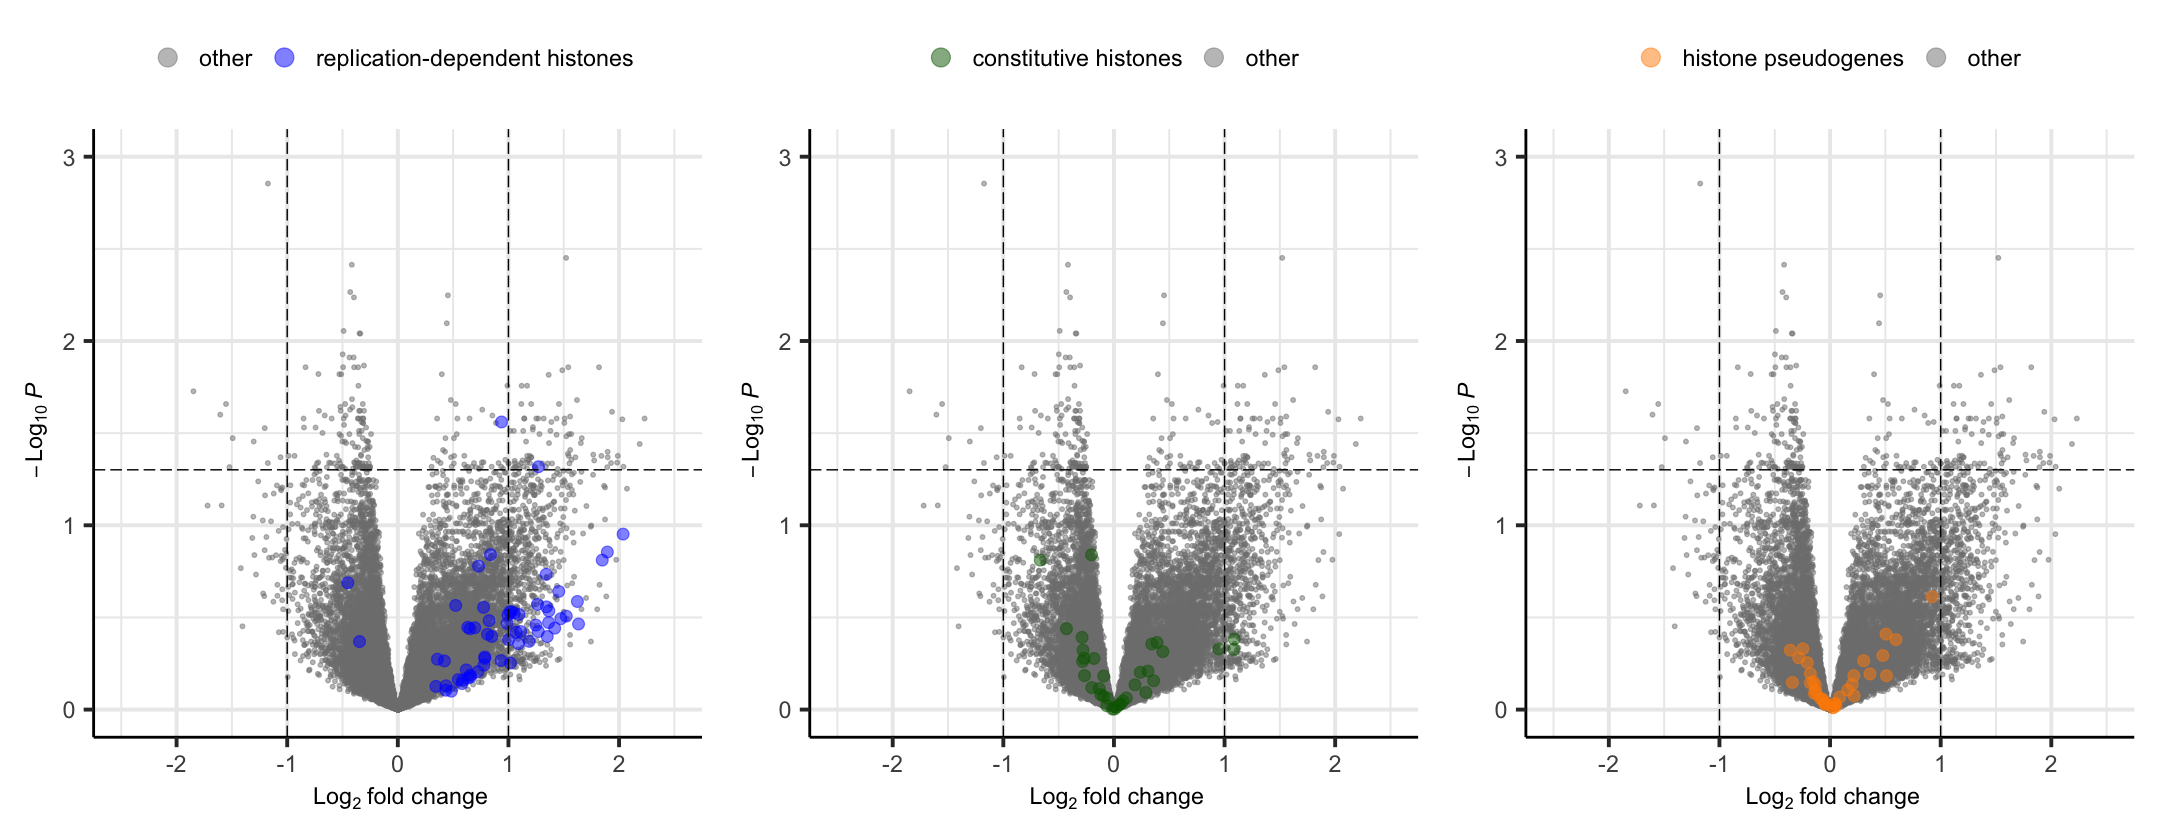

In [335]:
plt <- osc_volcano_ii(stats_df,rdh,'replication-dependent histones') +
osc_volcano_ii(stats_df,nrdh,'constitutive histones') + 
osc_volcano_ii(stats_df,H_pseudogenes, 'histone pseudogenes')

write_plot(plt,"rdh_volcano",11,4.5)
plt 

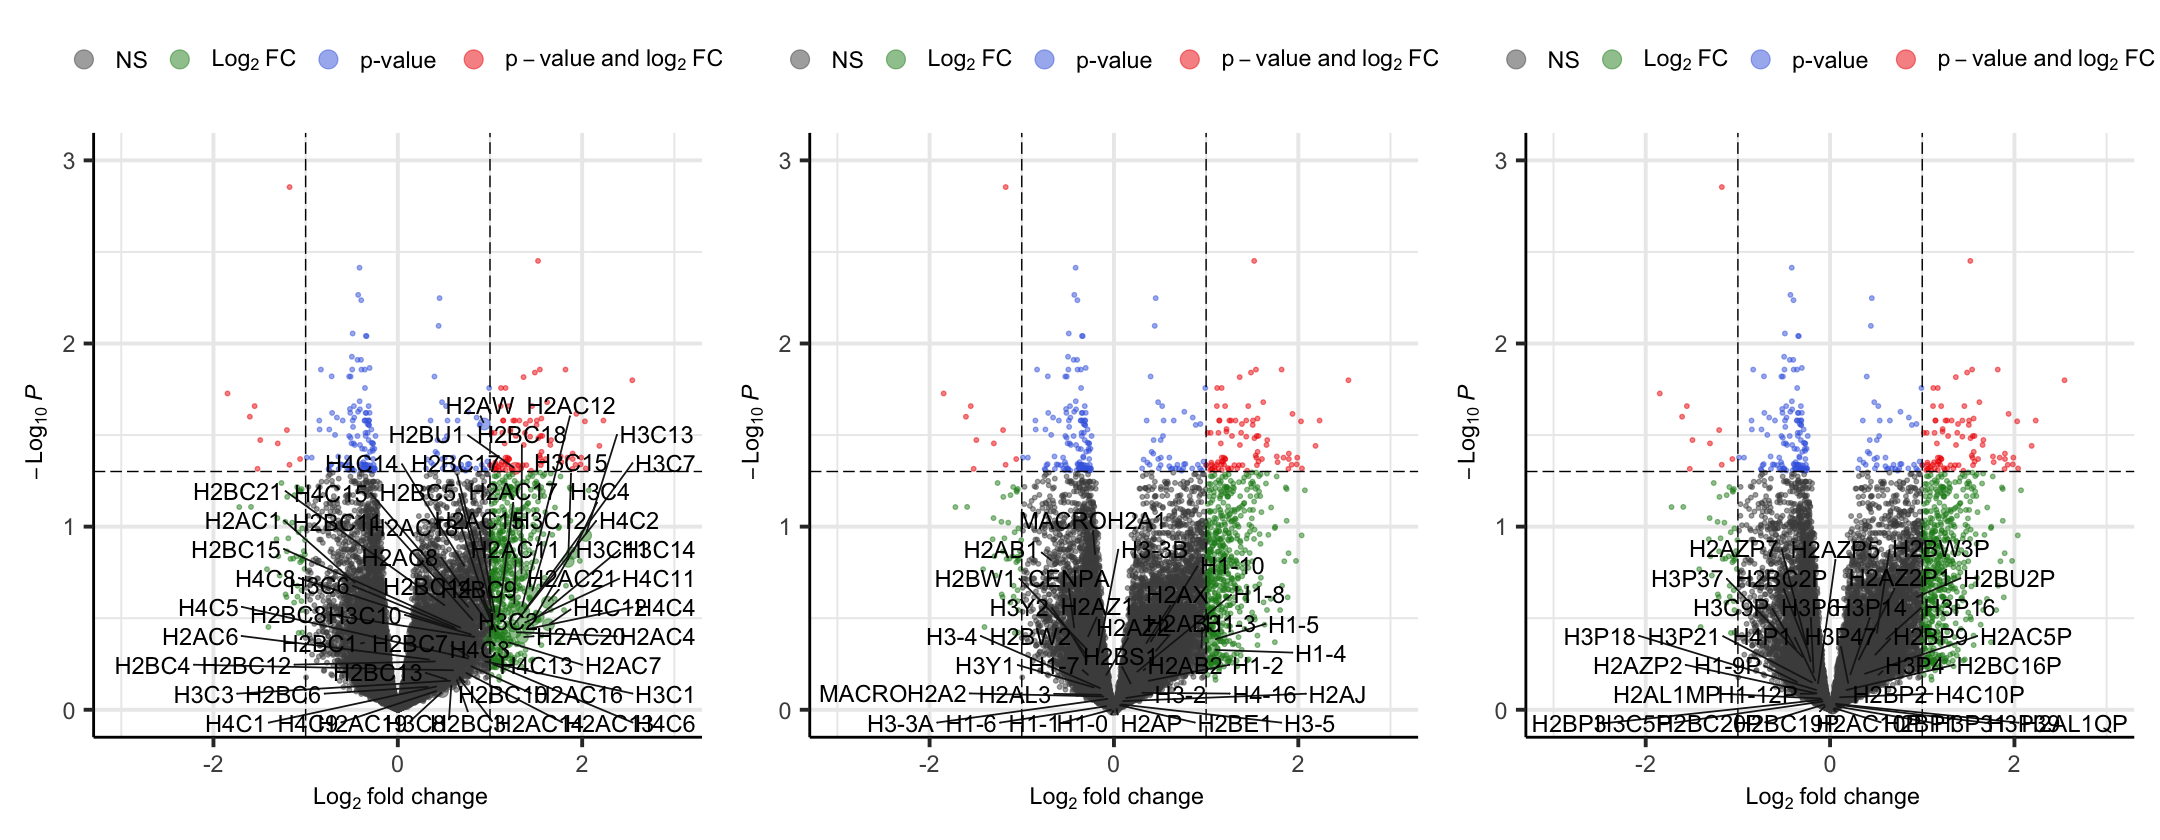

In [285]:
osc_volcano_i(stats_df,rdh) +
osc_volcano_i(stats_df,nrdh) + 
osc_volcano_i(stats_df,H_pseudogenes)

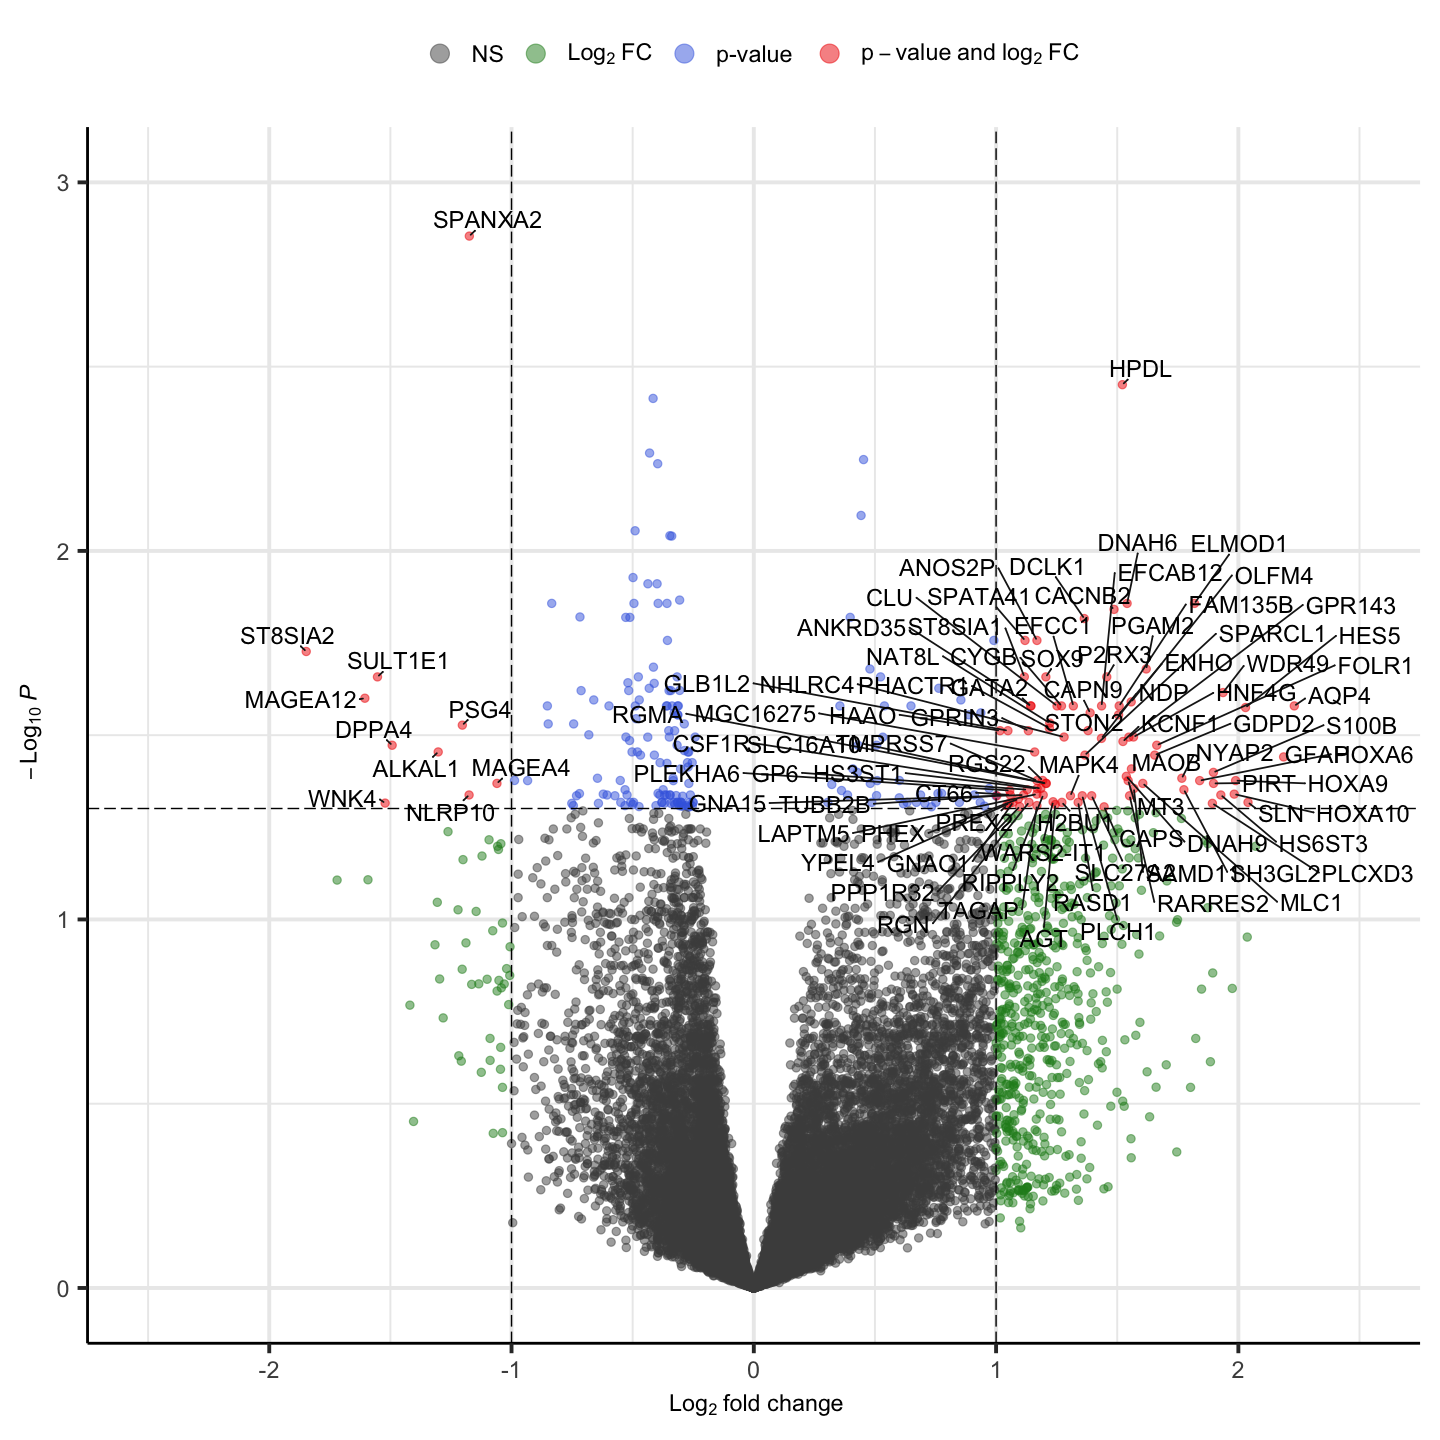

In [286]:
plt <- osc_volcano_iv(stats_df)
write_plot(plt,"sig_volcano",11,11)
plt

Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_vline()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_vline()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_vline()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_vline()`).”


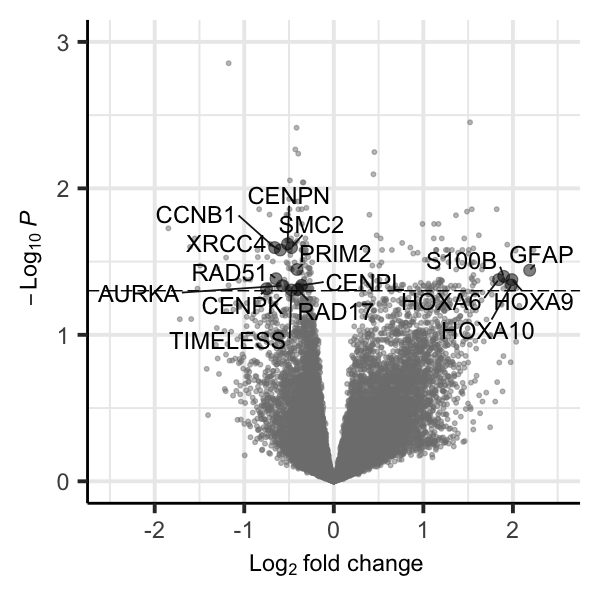

In [287]:
plt <- osc_volcano_v(stats_df)
write_plot(plt,"selected_volcano",5,5)
plt

In [301]:
# Read the tab-separated file
read_gmt = function(file_path="out/dsbr-sets.gmt"){
    data <- readLines(file_path)
    
    # Initialize an empty list to store named vectors
    named_vectors <- list()
    
    # Process each line
    for (line in data) {
      # Split the line by tab
      parts <- strsplit(line, "\t")[[1]]
      
      # The first part is the vector name
      vector_name <- parts[1]
      
      # The third part and onwards are the vector values
      vector_values <- (parts[3:length(parts)])
      
      # Create the named vector and add it to the list
      named_vectors[[vector_name]] <- vector_values
    }
    return(named_vectors)
}

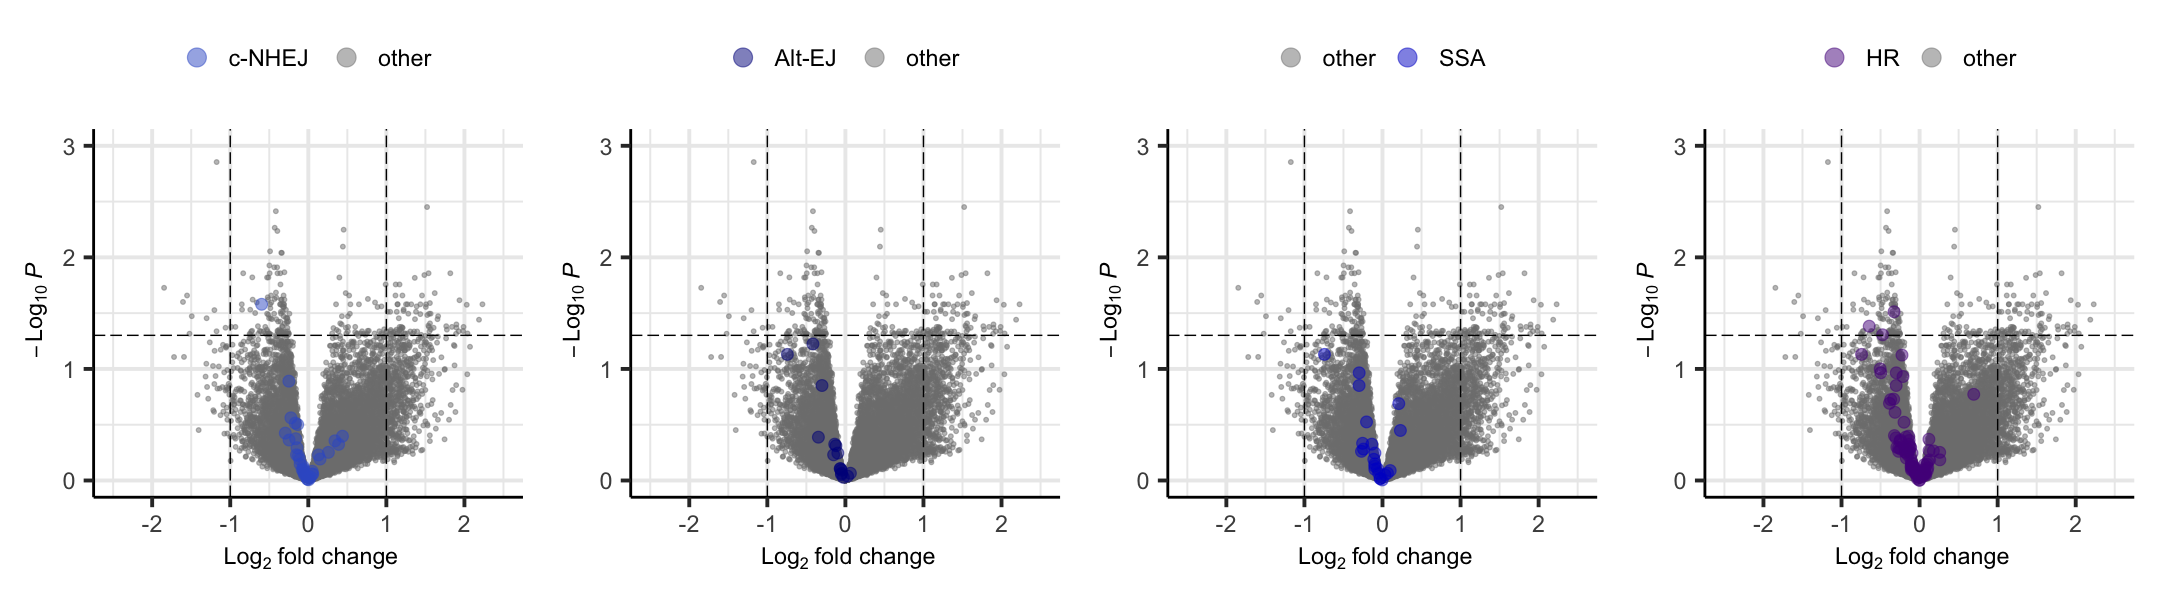

In [337]:
dsbr_sets = read_gmt()
plt <- osc_volcano_ii(stats_df,dsbr_sets[["c-NHEJ"]],'c-NHEJ') |
osc_volcano_ii(stats_df,dsbr_sets[["Alt-EJ"]],'Alt-EJ') |
osc_volcano_ii(stats_df,dsbr_sets[["SSA"]], 'SSA') | 
osc_volcano_ii(stats_df,dsbr_sets[["HR"]], 'HR')
options(repr.plot.width=18, repr.plot.height=5)
write_plot(plt,"dsbr_volcano",11,4)

plt 

In [306]:
dsbr_sets

$`c-NHEJ`
 [1] "UVRAG"   "POLM"    "PAXIP1"  "ATM"     "WRN"     "PARP3"   "TP53BP1"
 [8] "PRKDC"   "PNKP"    "XRCC6"   "APLF"    "PAXX"    "XRCC5"   "RNF168" 
[15] "XRCC4"   "DCLRE1C" "H2AX"    "TDP1"    "MDC1"    "SHLD2"   "POLL"   
[22] "LIG4"    "SHLD1"   "ERCC6"   "NHEJ1"   "FOXK1"   "BRCA1"   "ZBTB7A" 
[29] "RIF1"    "RNF8"    "ERCC8"   "CHEK2"   "TDP2"    "APTX"    "MAD2L2" 

$`Alt-EJ`
 [1] "BRCA1" "PARP1" "HELQ"  "POLQ"  "PARP2" "XRCC1" "LIG3"  "LIG1"  "PRKDC"
[10] "HMCES" "NBN"   "MRE11" "RAD50" "RBBP8" "FEN1"  "CDK1" 

$SSA
 [1] "WRN"    "SLX4"   "SLX1B"  "NBN"    "FANCG"  "RPA3"   "MRE11"  "RAD50" 
 [9] "RPA1"   "RAD52"  "RPA2"   "HELQ"   "EXO1"   "BLM"    "FANCA"  "RNF138"
[17] "ERCC1"  "ERCC4"  "RBBP8"  "DNA2"   "CDK1"   "OGG1"   "PARP2" 

$HR
 [1] "ACTL6A"   "RAD54L"   "H3-3A"    "RMI2"     "SLX4"     "NBN"     
 [7] "RFC1"     "MRE11"    "PARP1"    "RPA2"     "SMARCAD1" "GEN1"    
[13] "RAD51B"   "RBBP8"    "ABRAXAS1" "ERCC6"    "BRCA1"    "PCNA"    
[19] "MRNIP"    "RUVBL1"   "PARP2"    "RAD51AP1" "WRN"      "FUS"     
[25] "PIAS4"    "FANCB"    "RUVBL2"   "SMC5"     "TRIP13"   "BRD8"    
[31] "RAD54B"   "POGZ"     "UIMC1"    "WAS"      "RECQL5"   "ACTR2"   
[37] "MRGBP"    "ING3"     "TRRAP"    "ACTB"     "RAD51C"   "KAT5"    
[43] "TOP3A"    "MORF4L2"  "EPC1"     "RPA1"     "HELQ"     "BRIP1"   
[49] "XRCC2"    "EXO1"     "BRCA2"    "SMC6"     "RAD51"    "EP400"   
[55] "VPS72"    "MORF4L1"  "EPC2"     "MUS81"    "MEAF6"    "YEATS4"  
[61] "HDGFL2"   "TIMELESS" "RMI1"     "NSMCE2"   "EME1"     "RPA3"    
[67] "RAD50"    "MBTD1"    "WRAP53"   "RAD51D"   "BLM"      "ARID2"   
[73] "DMAP1"    "WDR48"    "ATRX"     "PALB2"    "XRCC3"    "DAXX"    
[79] "DNA2"     "CDK1"     "FOXK1"    "BARD1"    "MMS19"    "EME2"

In [340]:
stats_df

ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CP,3.1852726,4.3783694,5.348147,1.045043e-07,0.001398686,7.232135
SPANXA2,-1.1741806,-6.4833032,-5.365137,9.531813e-08,0.001398686,6.950405
UBE2G1,-0.4157035,5.1240460,-5.023526,5.763133e-07,0.003856689,5.799604
PDCL,-0.4301559,4.4312630,-4.911989,1.013490e-06,0.005425818,5.274501
HPDL,1.5212549,-0.2749044,5.096121,3.966852e-07,0.003539490,5.094412
MESD,-0.3967121,5.4860200,-4.830917,1.516774e-06,0.005800145,4.902433
TCEANC,0.4529311,1.8550723,4.867271,1.266851e-06,0.005651846,4.732986
INO80B,0.4427228,3.7076683,4.737594,2.394730e-06,0.008012766,4.456962
DONSON,-0.4900008,3.0306816,-4.693402,2.964615e-06,0.008817424,4.269537


In [320]:
'BRCA1' %in% (dsbr_sets[['Alt-EJ']])

[1] TRUE

In [315]:
'H2AC1' %in% rdh

[1] TRUE

In [319]:
unname(dsbr_sets[['Alt-EJ']])

[1] "BRCA1" "PARP1" "HELQ"  "POLQ"  "PARP2" "XRCC1" "LIG3"  "LIG1"  "PRKDC"
[10] "HMCES" "NBN"   "MRE11" "RAD50" "RBBP8" "FEN1"  "CDK1"